
# Decision Trees Tutorial — Notebook
This notebook demonstrates key aspects of decision trees: **impurity measures (Gini vs Entropy)**, **overfitting & tree depth**, **feature importance**, and **decision boundaries**. All code is runnable in a fresh Python environment with `scikit-learn`, `numpy`, `matplotlib`, and `pandas` installed.


In [1]:

# Imports & helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import os

os.makedirs('/mnt/data/figures', exist_ok=True)

def plot_decision_boundary(clf, X, y, ax=None, title=None, mesh_step=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step),
                         np.arange(y_min, y_max, mesh_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=30)
    if title:
        ax.set_title(title)
    return ax


Gini test accuracy: 0.947
Entropy test accuracy: 0.933


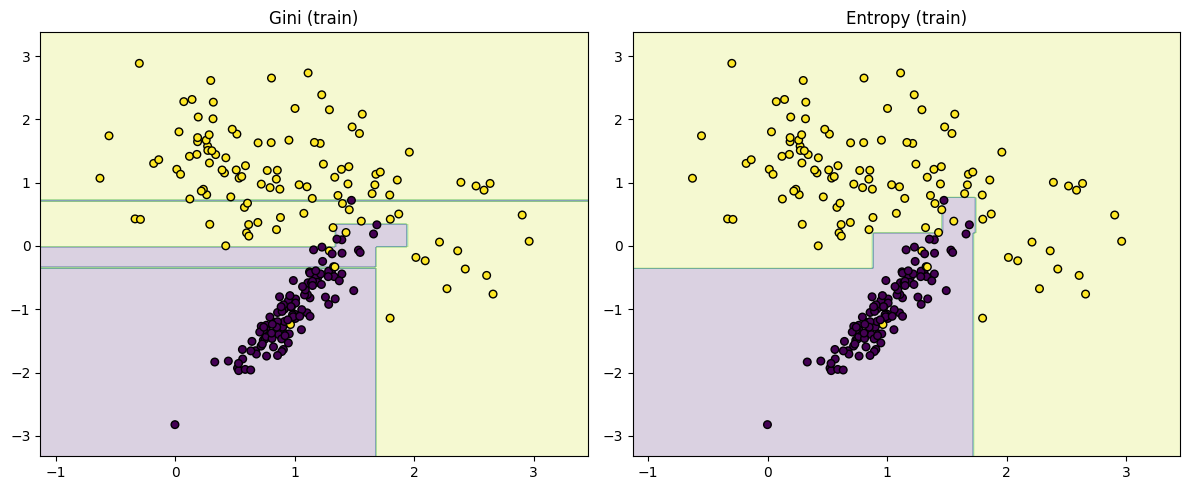

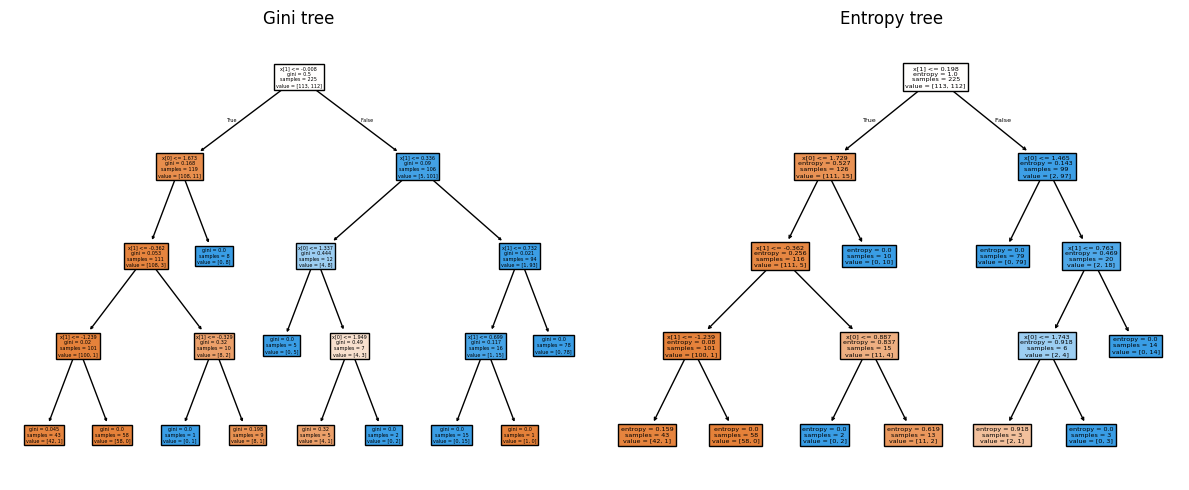

In [6]:

# Gini vs Entropy on a simple dataset
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=0)
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

clf_gini.fit(X_train, y_train)
clf_entropy.fit(X_train, y_train)

acc_gini = accuracy_score(y_test, clf_gini.predict(X_test))
acc_entropy = accuracy_score(y_test, clf_entropy.predict(X_test))

print(f'Gini test accuracy: {acc_gini:.3f}')
print(f'Entropy test accuracy: {acc_entropy:.3f}')

# Plot trees and decision boundaries
fig, axs = plt.subplots(1, 2, figsize=(12,5))
plot_decision_boundary(clf_gini, X_train, y_train, ax=axs[0], title='Gini (train)')
plot_decision_boundary(clf_entropy, X_train, y_train, ax=axs[1], title='Entropy (train)')
plt.tight_layout()
plt.savefig('gini_vs_entropy_boundaries.png', dpi=150)
plt.show()

# Save tree visualizations
fig2, axs2 = plt.subplots(1,2, figsize=(12,5))
plot_tree(clf_gini, ax=axs2[0], filled=True)
axs2[0].set_title('Gini tree')
plot_tree(clf_entropy, ax=axs2[1], filled=True)
axs2[1].set_title('Entropy tree')
plt.tight_layout()
plt.savefig('gini_entropy_trees.png', dpi=150)
plt.show()


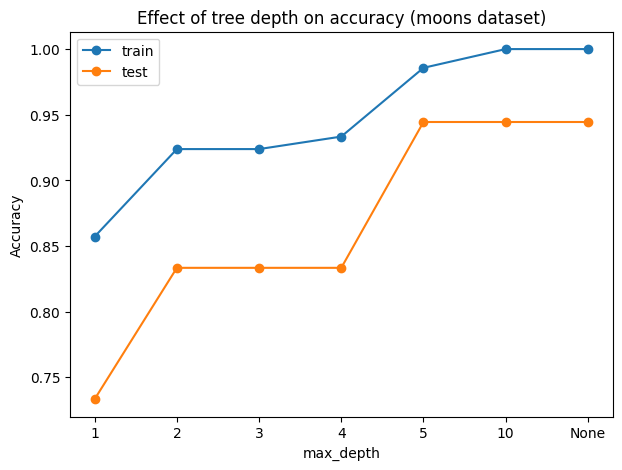

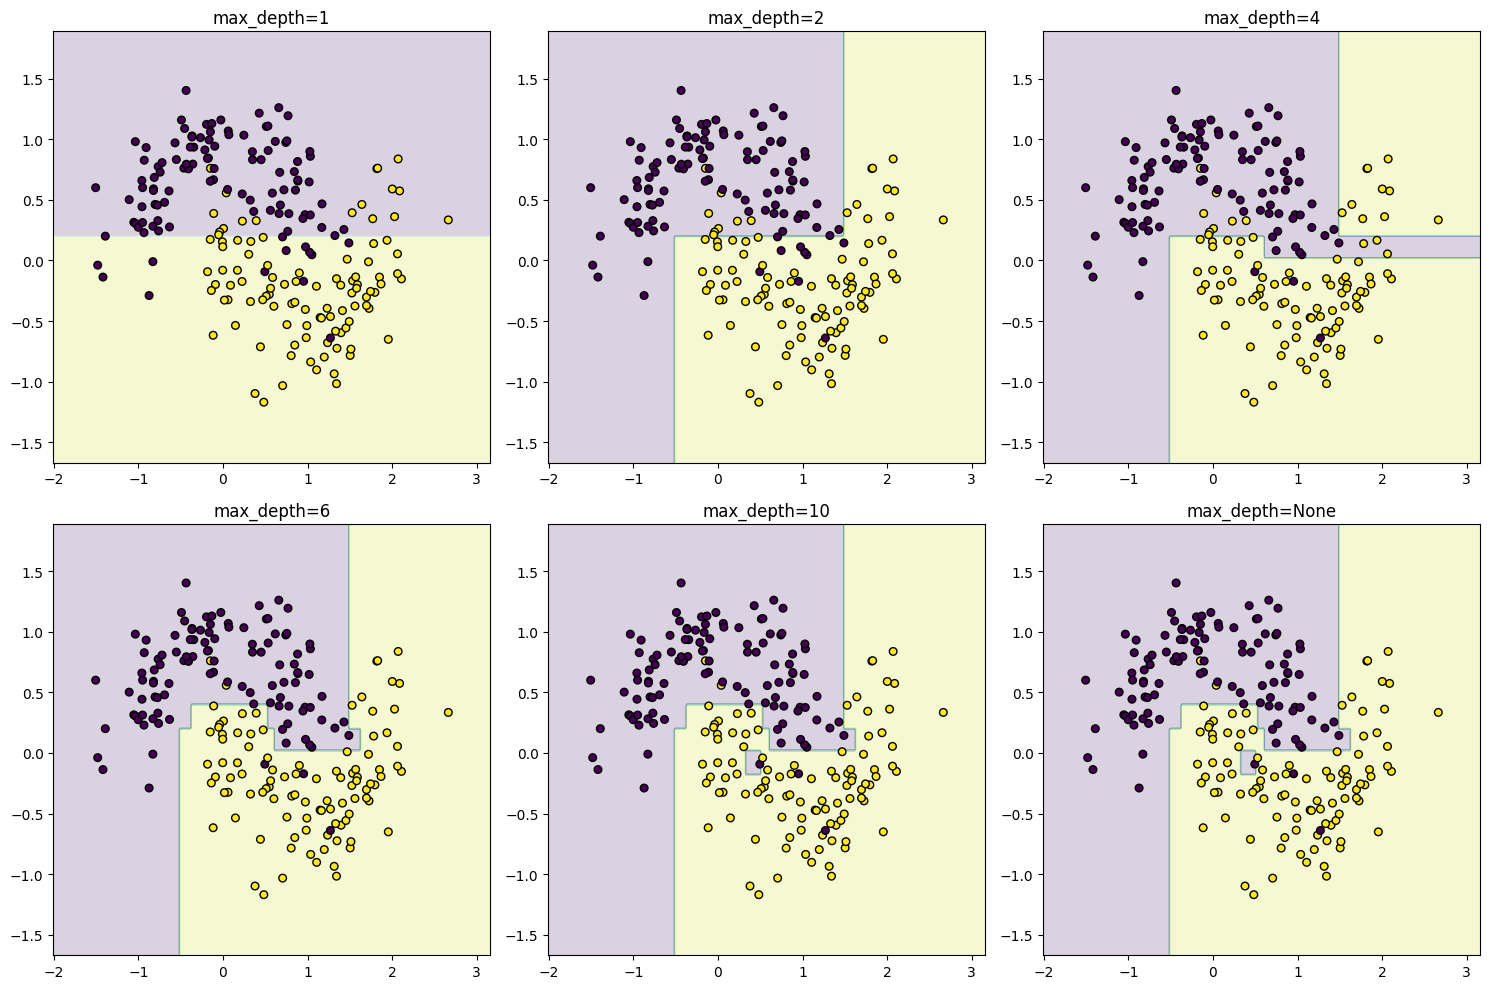

In [7]:

# Effect of max_depth on overfitting
X2, y2 = make_moons(n_samples=300, noise=0.25, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

depths = [1, 2, 3, 4, 5, 10, None]
train_scores = []
test_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X2_train, y2_train)
    train_scores.append(accuracy_score(y2_train, clf.predict(X2_train)))
    test_scores.append(accuracy_score(y2_test, clf.predict(X2_test)))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,5))
ax.plot([str(d) for d in depths], train_scores, marker='o', label='train')
ax.plot([str(d) for d in depths], test_scores, marker='o', label='test')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of tree depth on accuracy (moons dataset)')
ax.legend()
plt.savefig('depth_vs_accuracy.png', dpi=150)
plt.show()

# Visualize decision boundaries for selected depths
fig, axs = plt.subplots(2, 3, figsize=(15,10))
selected = [1, 2, 4, 6, 10, None]
for ax, d in zip(axs.ravel(), selected):
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X2_train, y2_train)
    title = f'max_depth={d}'
    plot_decision_boundary(clf, X2_train, y2_train, ax=ax, title=title)
plt.tight_layout()
plt.savefig('depth_boundaries.png', dpi=150)
plt.show()


Impurity-based importances:
  feature  importance
1      X1    0.642115
0      X0    0.250374
5      X5    0.065146
2      X2    0.031845
3      X3    0.008016
4      X4    0.002504

Permutation importances:
  feature  perm_importance_mean
1      X1              0.303333
0      X0              0.126889
4      X4              0.002222
3      X3             -0.004889
5      X5             -0.006222
2      X2             -0.008222


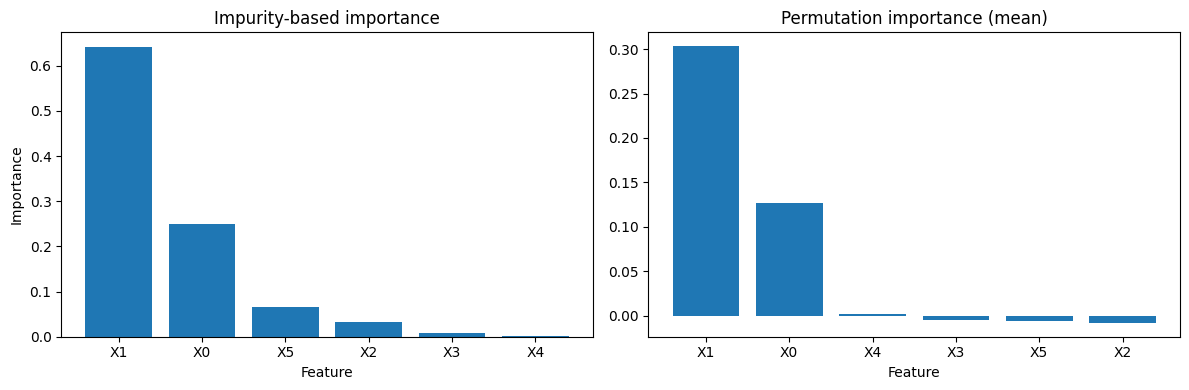

In [8]:

# Feature importance demo
# Create a dataset with informative and noisy features
from sklearn.datasets import make_classification
X3, y3 = make_classification(n_samples=500, n_features=6, n_informative=2, n_redundant=0,
                             n_repeated=0, random_state=0, shuffle=False)
feature_names = [f'X{i}' for i in range(X3.shape[1])]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=1)

clf_full = DecisionTreeClassifier(random_state=0)
clf_full.fit(X3_train, y3_train)

# Impurity-based importance
importances = clf_full.feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
print('Impurity-based importances:')
print(imp_df)

# Permutation importance
perm = permutation_importance(clf_full, X3_test, y3_test, n_repeats=30, random_state=0)
perm_df = pd.DataFrame({'feature': feature_names, 'perm_importance_mean': perm.importances_mean}).sort_values('perm_importance_mean', ascending=False)
print('\nPermutation importances:')
print(perm_df)

# Plot importances
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].bar(imp_df['feature'], imp_df['importance'])
axs[0].set_title('Impurity-based importance')
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('Importance')
axs[1].bar(perm_df['feature'], perm_df['perm_importance_mean'])
axs[1].set_title('Permutation importance (mean)')
axs[1].set_xlabel('Feature')
plt.tight_layout()
plt.savefig('feature_importances.png', dpi=150)
plt.show()


In [3]:
#GitHub Link for reference :
from IPython.display import Markdown
Markdown('[GitHub Link](https://github.com/Valluru-Abhinaya/Machine-Learning---Tutorial)')

[GitHub Link](https://github.com/Valluru-Abhinaya/Machine-Learning---Tutorial)